In [249]:
import torch
from neural_networks import TinySSD
import PIL
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.functional import F

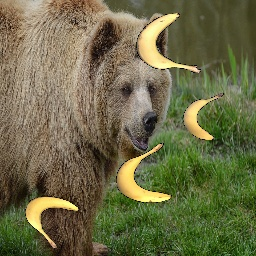

In [250]:
img = PIL.Image.open('images/banana.jpg')
img

In [251]:
data = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, True)
])(img).unsqueeze(0).to('cuda')
data.shape

torch.Size([1, 3, 256, 256])

In [252]:
model = TinySSD.load_from_checkpoint('./saved_checkpoints/tinyssd-bananadetection/epoch=19-step=640.ckpt')
model.eval()

TinySSD(
  (block_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

In [253]:
anchors, cls_pred, bbox_pred = model(data)
anchors.shape, cls_pred.shape, bbox_pred.shape

(torch.Size([1, 5444, 4]), torch.Size([1, 5444, 2]), torch.Size([1, 21776]))

In [254]:
def offset_inverse(anchors, offset_preds):
    anchor_centers = TinySSD.box_corner_to_center(anchors)
    pred_bbox_xy = (
        offset_preds[:, :2] * anchor_centers[:, 2:] / 10) + anchor_centers[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anchor_centers[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = TinySSD.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [255]:
predicted_bounding_boxes = offset_inverse(anchors.reshape(-1,4), bbox_pred.reshape(-1,4))
predicted_bounding_boxes.shape

torch.Size([5444, 4])

In [256]:
a = torch.tensor([[1,2,3,4],[8,7,6,5]])
a


tensor([[1, 2, 3, 4],
        [8, 7, 6, 5]])

In [257]:
torch.argsort(a, dim=-1, descending=True)

tensor([[3, 2, 1, 0],
        [0, 1, 2, 3]])

In [258]:
class_pred_probability = F.softmax(cls_pred, dim=2).permute(0,2,1)
torch.argsort(class_pred_probability,dim=-1,descending=True)
class_pred_probability.shape

torch.Size([1, 2, 5444])

In [259]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1:
            break
        iou = TinySSD.box_iou(boxes[i, :].reshape(-1, 4),
                              boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [260]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [261]:
def predict(X):
    model.eval()
    anchors, cls_preds, bbox_preds = model(X)
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

In [262]:
output = predict(data)
output

tensor([[ 0.0000,  0.9994,  0.4456,  0.5801,  0.6638,  0.7873],
        [ 0.0000,  0.9947,  0.0737,  0.7700,  0.2922,  0.9663],
        [ 0.0000,  0.9912,  0.5417,  0.0767,  0.7447,  0.2662],
        [ 0.0000,  0.9873,  0.7190,  0.3634,  0.9166,  0.5655],
        [ 0.0000,  0.5906,  0.4537,  0.5142,  0.6512,  0.7241],
        [ 0.0000,  0.3262,  0.6995,  0.2866,  0.8973,  0.5008],
        [ 0.0000,  0.2499,  0.5943,  0.1002,  0.8030,  0.2989],
        [ 0.0000,  0.2425,  0.4314,  0.4631,  0.6413,  0.6565],
        [ 0.0000,  0.1941,  0.5371, -0.1076,  0.7429,  0.0969],
        [ 0.0000,  0.1884,  0.5724,  0.0220,  0.7875,  0.2179],
        [ 0.0000,  0.1665,  0.6841,  0.2332,  0.8817,  0.4281],
        [ 0.0000,  0.1265,  0.4630,  0.6702,  0.6421,  0.8607],
        [ 0.0000,  0.1161,  0.5330,  0.1184,  0.7052,  0.3315],
        [ 0.0000,  0.1057,  0.1359,  0.7761,  0.3668,  0.9467],
        [ 0.0000,  0.1044,  0.4131,  0.5411,  0.5811,  0.7772],
        [ 0.0000,  0.1036,  0.5193,  0.0

In [263]:
data.shape

torch.Size([1, 3, 256, 256])

In [264]:
def show_result(img, output, threshold):
    fig, ax = plt.subplots()
    ax.imshow(v2.ToPILImage()(img[0]))
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[2:4]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        print(bbox)
        for box in bbox:
            rect = Rectangle((box[0], box[1]), box[2]-box[0], box[3] -
                        box[1], linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rect)

[tensor([114.0668, 148.5057, 169.9361, 201.5559])]
[tensor([ 18.8696, 197.1270,  74.7918, 247.3778])]
[tensor([138.6719,  19.6258, 190.6486,  68.1571])]
[tensor([184.0674,  93.0404, 234.6414, 144.7791])]


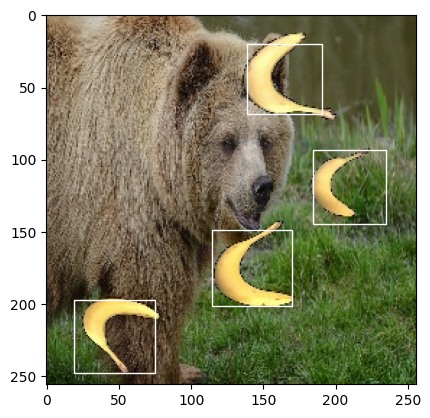

In [265]:
show_result(data, output.cpu().detach(), 0.9)